In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RediCell:
    
    def __init__(self, sides=None, spacing=None, t_step=None, molecule_types=None, wall=True):
        # sides in number of voxels
        # spacing in m
        # "wall" adds one extra cell each direction, set as barrier
        self.spacing = spacing
        # Should be a list of Molecule instances
        self.molecule_types = molecule_types
        self.num_types = len(self.molecule_types)
        self.mol_to_id = {mol.molecule_name: idx for idx, mol in enumerate(self.molecule_types)}
        self.id_to_mol = {idx: mol.molecule_name for idx, mol in enumerate(self.molecule_types)}
        self.wall = wall
        self.initialized = False
        self.voxel_matrix = []
        if sides == None:
            self.side_x = self.side_y = None
        elif isinstance(sides, int):
            self.side_x = sides
            self.side_y = sides
        else:
            self.side_x, self.side_y = sides
            
        if self.wall:
            self.true_x = self.side_x + 2
            self.true_y = self.side_y + 2
        else:
            self.true_x = self.side_x
            self.true_y = self.side_y

        self.t_step = t_step
        self.action_vector = None
        self.fig = None
        self.cumulative_t = 0
    
    def partition(self):
        # creates a list of list of Voxels
        if self.action_vector is None:
            self.construct_possible_actions()
            print(f'Action vector is {self.action_vector}')
        molecule_count = np.array([0 for mtype in self.molecule_types])
        self.voxel_matrix = []
        for x in range(self.true_x):
            voxel_row = []
            for y in range(self.true_y):
                voxel_row.append(Voxel(molecule_count=molecule_count.copy(), spacing=self.spacing, action_vector=self.action_vector.copy()))
            self.voxel_matrix.append(voxel_row)

        if self.wall:
            self.set_border_wall()
        self.edit_action_vector()
        self.voxel_matrix = np.array(self.voxel_matrix)

    def set_border_wall(self): 
        for y in range(self.true_y):
            self.voxel_matrix[0][y].is_barrier = True
            self.voxel_matrix[-1][y].is_barrier = True
        for x in range(self.true_x):
            self.voxel_matrix[x][0].is_barrier = True
            self.voxel_matrix[x][-1].is_barrier = True
    
    def edit_action_vector(self):
        # Edit action vector
        for x in range(self.true_x):
            for y in range(self.true_y):
                if x == 0: # up
                    self.voxel_matrix[x][y].action_vector[0:4*self.num_types:4] = 0
                if x == self.true_x - 1: # down
                    self.voxel_matrix[x][y].action_vector[1:4*self.num_types:4] = 0
                if y == 0: # left
                    self.voxel_matrix[x][y].action_vector[2:4*self.num_types:4] = 0
                if y == self.true_y - 1: # right
                    self.voxel_matrix[x][y].action_vector[3:4*self.num_types:4] = 0
        for x in range(1, self.true_x - 1):
            for y in range(1, self.true_y - 1):
                if self.voxel_matrix[x-1][y].is_barrier:
                    # print(f'row {x}, column {y}, row above is barrier')
                    self.voxel_matrix[x][y].action_vector[0:4*self.num_types:4] = 0
                if self.voxel_matrix[x+1][y].is_barrier:
                    # print(f'row {x}, column {y}, row below is barrier')
                    self.voxel_matrix[x][y].action_vector[1:4*self.num_types:4] = 0
                if self.voxel_matrix[x][y-1].is_barrier:
                    # print(f'row {x}, column {y}, column to the left is barrier')
                    self.voxel_matrix[x][y].action_vector[2:4*self.num_types:4] = 0
                if self.voxel_matrix[x][y+1].is_barrier:
                    # print(f'row {x}, column {y}, column to the right is barrier')
                    self.voxel_matrix[x][y].action_vector[3:4*self.num_types:4] = 0
        # for x in range(1, self.true_x - 1):
        #     for y in range(1, self.true_y - 1):
        #         print(f'row {x}, column {y}, action_vector {self.voxel_matrix[x][y].action_vector}')
    
    def plot_wall(self):
        voxel_map = np.zeros(self.voxel_matrix.shape)
        for x in range(self.true_x):
            for y in range(self.true_y):
                voxel_map[x][y] = self.voxel_matrix[x][y].is_barrier
        plt.imshow(voxel_map)
        
    def initialize(self):
        assert self.initialized == False
        # Set condition based on initial conditions
        # Set external conditions
        # Compile all possible reactions (diffuse to 4 neighbors, reactions, and do nothing)
        # Calculate largest possible timestep
        self.initialized = True

    def add_reaction_set(self, reaction_set=None):
        pass
    
    def list_reaction_set(self):
        pass
    
    def construct_possible_actions(self):
        # up, down, left, right for each kind of molecule
        # then reactions
        action_vector = []
        for mol in self.molecule_types:
            for direction in range(4): # up down left right
                # this results in unit of second per molecule
                action_vector.append(mol.diffusion_coefficient / self.spacing**2) 
        
        # for rx in self.reaction_set:
        #     action_vector.append(
        # pass
        self.action_vector = np.array(action_vector)
        print('Action list:')
        for mol in self.molecule_types:
            print(f'Diffusion of {mol.molecule_name} (4 directions)')
    
    def determine_maximum_timestep(self):
        print(f'Max time step is {1 / np.max(self.action_vector) / 4:.2e} s / particle per voxel (divide by max number of mol in one voxel)')
        return 1 / np.max(self.action_vector) / 4
        
    def add_molecules(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] = molecule_count
        # distribute molecules randomly
        pass

    def maintain_external_conditions(self):
        pass

    def react_diffuse(self, t_step):
        action_list = []
        for x in range(self.true_x):
            for y in range(self.true_y):
                if not self.voxel_matrix[x][y].is_barrier:
                    action = self.voxel_matrix[x][y].determine_action(t_step)
                    if action < len(self.action_vector):
                        # print(f'{x}, {y}: action {action}')
                        action_list.append([x, y, action])
        # Apply action
        for action in action_list:
            x, y, a = action
            if action[-1] % 4 == 0:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x-1][y].molecule_count[a//4] += 1
            if action[-1] % 4 == 1:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x+1][y].molecule_count[a//4] += 1
            if action[-1] % 4 == 2:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x][y-1].molecule_count[a//4] += 1
            if action[-1] % 4 == 3:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x][y+1].molecule_count[a//4] += 1

        self.cumulative_t += t_step
                
    def simulate(self, steps, t_step=None, show=False):
        if not self.initialized:
            self.initialize()
        if t_step is not None:
            self.t_step = t_step
        for step in range(steps):
            if step == 0: print(f'Simulate {steps} steps')
            if steps > 100 and step % (steps // 100) == 0 and step > 0:
                print(step, end=' ')
            self.maintain_external_conditions()
            self.react_diffuse(self.t_step)
            if show:
                self.plot_type_count('A')

    def plot_type_count(self, mol_type):
        cmaps = ['gist_gray_r', 'bone_r']
        img = []
        if type(mol_type)==str:
            mol_type=[mol_type]
        for idx, mol in enumerate(mol_type):
            voxel_map = np.zeros(self.voxel_matrix.shape)
            for x in range(self.true_x):
                for y in range(self.true_y):
                    voxel_map[x][y] = self.voxel_matrix[x][y].molecule_count[self.mol_to_id[mol]]
            img.append(plt.imshow(voxel_map, cmap=cmaps[idx], vmax=5, extent=[0, self.spacing * self.true_x, 0, self.spacing * self.true_y], alpha=0.5))
        plt.title(f't = {self.cumulative_t:.2e} s')
        plt.grid(alpha=0.3)
        plt.show()
    
class Voxel:
    def __init__(self, molecule_count=[], spacing=None, is_barrier=False, action_vector=None):
        self.molecule_count = molecule_count
        self.is_barrier = is_barrier
        self.spacing = spacing
        self.action_vector = action_vector
    def add_molecule(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] += molecule_count
    def set_molecule(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] = molecule_count
    def compute_transition_vector(self, t):
        return np.pad(np.cumsum(np.repeat(self.molecule_count, 4) * self.action_vector * t), (0, 1), constant_values=1)
    def determine_action(self, t):
        transition_vector = self.compute_transition_vector(t)
        if np.sum(transition_vector[-2]) > 1:
            print('Warning: transition probability > 1')
        return np.argmax(np.random.random() < transition_vector)
    
class Molecule:
    def __init__(self, molecule_name, diffusion_coefficient):
        # diffusion_coefficient in m^2 / s, so a value like 1e-13 m^2/s is likely
        self.molecule_name = molecule_name
        self.diffusion_coefficient = diffusion_coefficient

class ReactionSet:
    def __init__(self):
        self.reaction_set = {}
    def add_reaction(self, reagent, reaction_coefficient):
        # reagent can be [typeA, typeB] for bimolecular reaction
        # or [typeA] or typeA for unimolecular reaction
        self.reaction_set[frozenset(reagent)] = reaction_coefficient
        

In [3]:
mol_A = Molecule('A', diffusion_coefficient=8.15e-14)
mol_B = Molecule('B', diffusion_coefficient=1.5e-13)

In [4]:
a = RediCell(sides=[32, 32], spacing=31.25e-9, molecule_types=[mol_A, mol_B], t_step=2e-3)

In [5]:
a.mol_to_id

{'A': 0, 'B': 1}

In [6]:
a.id_to_mol

{0: 'A', 1: 'B'}

In [7]:
a.partition()

Action list:
Diffusion of A (4 directions)
Diffusion of B (4 directions)
Action vector is [ 83.456  83.456  83.456  83.456 153.6   153.6   153.6   153.6  ]


In [8]:
a.voxel_matrix[2:5, 2:5]

array([[<__main__.Voxel object at 0x7febe971cc70>,
        <__main__.Voxel object at 0x7febe9712290>]], dtype=object)

In [9]:
a.construct_possible_actions()

Action list:
Diffusion of A (4 directions)
Diffusion of B (4 directions)


In [10]:
a.action_vector

array([ 83.456,  83.456,  83.456,  83.456, 153.6  , 153.6  , 153.6  ,
       153.6  ])

In [11]:
np.random.randint(1, 32, 5)

array([21, 25, 23,  2, 17])

In [12]:
for i in range(1, 5):
    for j in range(1, 5):
        a.voxel_matrix[i, j].molecule_count = np.array([3, 0])
for i in range(28, 32):
    for j in range(28, 32):
        a.voxel_matrix[i, j].molecule_count = np.array([0, 3])

In [13]:
a.voxel_matrix[32, 5].action_vector

array([ 83.456,   0.   ,  83.456,  83.456, 153.6  ,   0.   , 153.6  ,
       153.6  ])

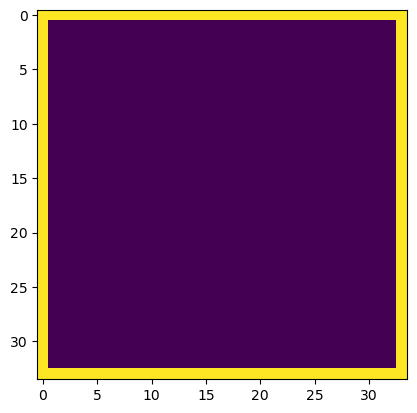

In [14]:
a.plot_wall()

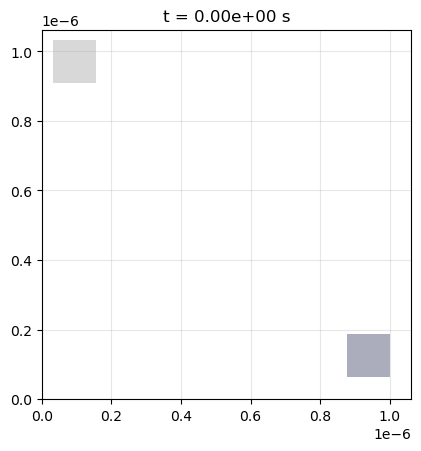

In [15]:
a.plot_type_count(['A', 'B'])

In [16]:
a.determine_maximum_timestep()

Max time step is 1.63e-03 s / particle per voxel (divide by max number of mol in one voxel)


0.0016276041666666667

Simulate 2000 steps
20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 

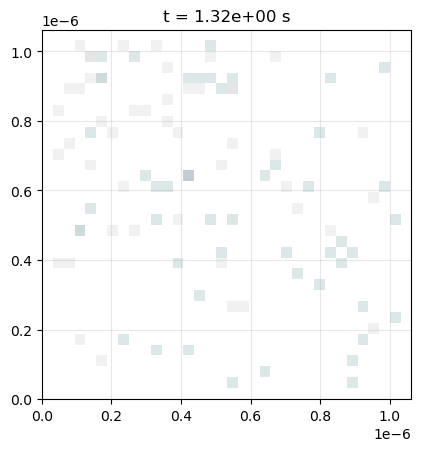

In [37]:
a.simulate(2000, t_step=3e-4, show=False)
a.plot_type_count(['A', 'B'])

In [38]:
r = ReactionSet()

In [26]:
r.reaction_set

{frozenset({'A', 'B'}): 3.5e-05}

In [29]:
r.reaction_set[frozenset(['A','B'])]

3.5e-05

2